In [254]:
import sys 
import os
sys.path.append(os.path.abspath("/Users/mouginot/work/helpmetric"))
import cymetrichelper as cyh
import pandahelper as pdh


import cymetric as cym
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from cymetric import graphs as cgr
from cymetric import timeseries as tm

%matplotlib inline

In [270]:
from cymetric.tools import format_nucs, reduce, merge, add_missing_time_step
def SWU(evaler, facilities=()):
    """
    Shape the reduced SWU Data Frame. Applying nuclides/facilities selection when required.

    Parameters
    ----------
    evaler : evaler
    facilities :  of the facility
    nucs :  of nuclide to select.
    """

    # Get inventory table
    df = evaler.eval('TimeSeriesEnrichmentSWU')
    agents = evaler.eval('AgentEntry')

    rdc_table = []  # because we want to get rid of the nuclide asap
 
    if len(facilities) != 0:
        agents = agents[agents['Prototype'].isin(facilities)]
        rdc_table.append(['AgentId', agents['AgentId'].tolist()])

    df = reduce(df, rdc_table)

    base_col = ['SimId', 'AgentId']
    added_col = base_col + ['Prototype']
    df = merge(df, base_col, agents, added_col)

    df = df[['Time', 'Value']].groupby(['Time']).sum()
    df.reset_index(inplace=True)
    return df




In [276]:
f_civ = "civilian/main.sqlite"
f_m_a0_b0 = "civ_mil_A0_B0/main.sqlite"
f_m_a0 = "civ_mil_A0/main.sqlite"
f_m_a1 = "civ_mil_A1/main.sqlite"
f_m_a2 = "civ_mil_A2/main.sqlite"
f_m_b0 = "civ_mil_B0/main.sqlite"
f_m_b1 = "civ_mil_B1/main.sqlite"



db_civ = cym.dbopen(f_civ)
db_m_a0_b0 = cym.dbopen(f_m_a0_b0)
db_m_a0 = cym.dbopen(f_m_a0)
db_m_a1 = cym.dbopen(f_m_a1)
db_m_a2 = cym.dbopen(f_m_a2)
db_m_b0 = cym.dbopen(f_m_b0)
db_m_b1 = cym.dbopen(f_m_b1)


ev_civ = cym.Evaluator(db=db_civ, write=False)
ev_m_a0_b0 = cym.Evaluator(db=db_m_a0_b0, write=False)
ev_m_a0 = cym.Evaluator(db=db_m_a0, write=False)
ev_m_a1 = cym.Evaluator(db=db_m_a1, write=False)
ev_m_a2 = cym.Evaluator(db=db_m_a2, write=False)
ev_m_b0 = cym.Evaluator(db=db_m_b0, write=False)
ev_m_b1 = cym.Evaluator(db=db_m_b1, write=False)




In [384]:
evs = [ev_civ, ev_m_a0_b0, ev_m_a0, ev_m_a1, ev_m_a2, ev_m_b0, ev_m_b1]
def loop(method, fac1=(), fac2=(), nucs=(), x_label='', y_label=''):
    pdfs = []
    val =''
    for i, ev in enumerate(evs):
        if method.__name__ == "transactions":
           val = 'Mass'
           from cymetric.timeseries import transactions
           pdfs.append(cyh.month2year(method(ev, senders=fac1, receivers=fac2, nucs=nucs),
                                      1, 12, val))
           pdfs[i]['Time'] +=0.1*i
        elif method.__name__ == "trucks":
           val = 'Mass'
           pdfs.append(cyh.month2year(method(ev, senders=fac1, receivers=fac2),
                                      1, 12, val))
           pdfs[i]['Time'] +=0.1*i

        elif method.__name__ == "HEUSQ":
           val = 'Mass'
           pdfs.append(cyh.month2year(method(ev, senders=fac1, receivers=fac2),
                                      1, 12, val))
           pdfs[i]['Time'] +=0.1*i

        elif method.__name__ == "inventories":
            val = 'Quantity'
            from cymetric.timeseries import inventories
            pdfs.append(cyh.month2year(method(ev, facilities=fac1, nucs=nucs),
                                      1, 12, val))
            pdfs[i]['Time'] +=0.1*i
        elif method.__name__ == "SWU":
            val = 'Value'
            pdfs.append(cyh.month2year(method(ev, facilities=fac1),
                                      1, 12, val))
            pdfs[i]['Time'] +=0.1*i
        elif method.__name__ == "get_power":
            val = 'Value'
            pdfs.append(cyh.month2year(method(ev, facilities=fac1),
                                      1, 12, val))
            pdfs[i]['Time'] +=0.1*i
    
    ax = pdfs[0].plot(subplots=True, x='Time', y=val, style=' ',marker='x', color='blue', label='Civilian')
    pdfs[1].plot(ax = ax, subplots=True, x='Time', y=val, style=' ', marker='x', color='green', label='Mil A0-B0')
    pdfs[2].plot(ax = ax, subplots=True, x='Time', y=val, style=' ', marker='+', color='green', label='Mil A0')
    pdfs[3].plot(ax = ax, subplots=True, x='Time', y=val, style=' ', marker='+', color='orange', label='Mil A1')
    pdfs[4].plot(ax = ax, subplots=True, x='Time', y=val, style=' ', marker='+', color='pink', label='Mil A2')
    pdfs[5].plot(ax = ax, subplots=True, x='Time', y=val, style=' ', marker='1', color='red', label='Mil B0')
    pdfs[6].plot(ax = ax, subplots=True, x='Time', y=val, style=' ', marker='1', color='green', label='Mil B1')





    plt.ylabel(x_label)
    plt.xlabel(y_label)
    plt.grid()

    return pdfs

(0, 30)

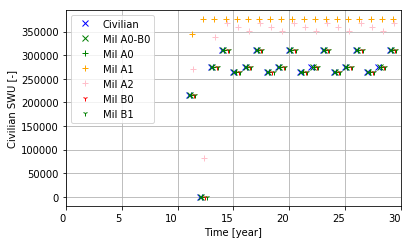

In [385]:
SWU_civ = loop(SWU, ['civ_enrichment'],x_label='Civilian SWU [-]', y_label='Time [year]')
plt.xlim(0,30)

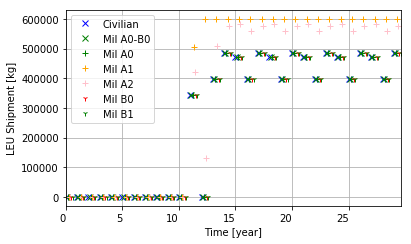

In [386]:
trans_civ = loop(tm.transactions, ['civ_enrichment'],x_label='LEU Shipment [kg]', y_label='Time [year]')

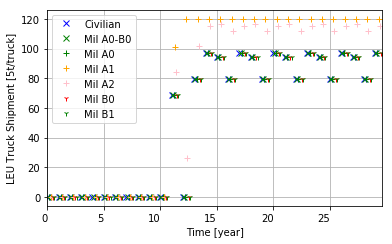

In [387]:
def trucks(ev, senders=(), receivers=()):
    df = tm.transactions(ev, senders=senders, receivers=receivers)
    df['Mass'] *= 1/5000
    return df
trucks_civ = loop(trucks, fac1=['civ_enrichment'],x_label='LEU Truck Shipment [5t/truck]', y_label='Time [year]')

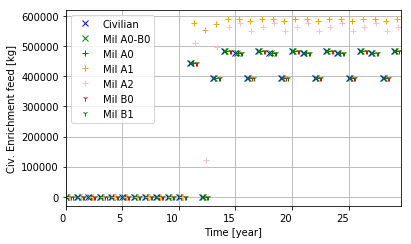

In [388]:
trans_conversion = loop(tm.transactions, 
                        fac1=['conversion'], 
                        fac2=['civ_enrichment'], 
                        x_label='Civ. Enrichment feed [kg]', 
                        y_label='Time [year]')

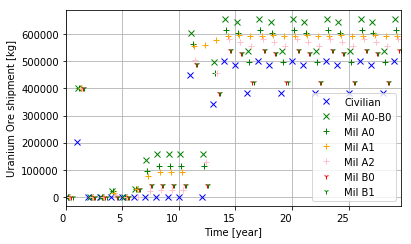

In [389]:
trans_mines = loop(tm.transactions, 
                   fac1=['milling'],
                   x_label='Uranium Ore shipment [kg]',
                   y_label='Time [year]')

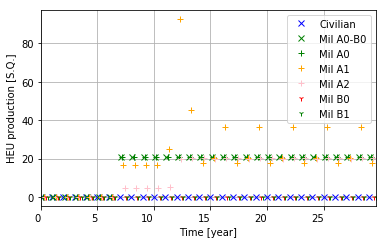

In [390]:
def HEUSQ(ev, senders=(), receivers=()):
    df = tm.transactions(ev, senders=senders, receivers=receivers)
    df['Mass'] *= 1/25
    return df
trans_mines = loop(HEUSQ, 
                   fac1=['mil_enrichment'],
                   fac2=['mil_str_fiss'],
                   x_label='HEU production [S.Q.]', 
                   y_label='Time [year]')

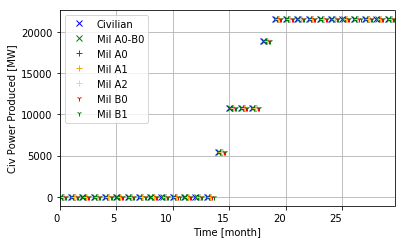

In [391]:
power = loop(tm.get_power, 
             x_label='Civ Power Produced [MW]', 
             y_label='Time [month]')


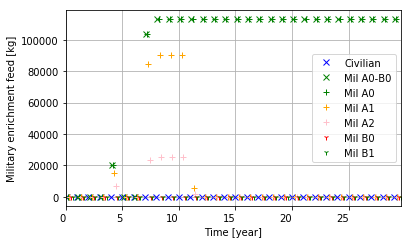

In [392]:
trans_mines = loop(tm.transactions, 
                   fac1=['conversion'],
                   fac2=['mil_enrichment'],
                   x_label='Military enrichment feed [kg]',
                   y_label='Time [year]')

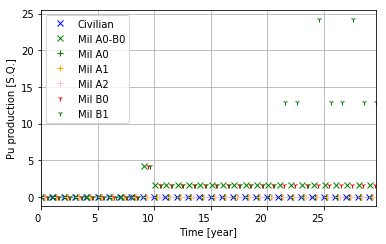

In [393]:
def PUSQ(ev, senders=(), receivers=()):
    df = tm.transactions(ev, senders=senders, receivers=receivers)
    df['Mass'] *= 1/4
    return df
trans_mines = loop(HEUSQ, 
                   fac1=['reprocessing'],
                   fac2=['mil_str_fiss'],
                   x_label='Pu production [S.Q.]', 
                   y_label='Time [year]')